## This notebook aims to visualize and test the EONIA distribution produced by GAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import scipy.stats as stats


from dotenv.main import load_dotenv
load_dotenv(override=True)

import os

## Note to self -- We only test EONIA

In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    # Select only the third, sixth, and seventh columns

    # 2, 5, 6
    selected_columns = df.iloc[:, [6]]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [3]:
asset_names = returns_df.columns

## Define a Measure of Success

What constetutes a good generated distribution for EONIA.

This is due to the fact that on Mondays you factor in the weekend.

<Axes: title={'center': 'EONIA Returns for 2006-05'}, xlabel='Date'>

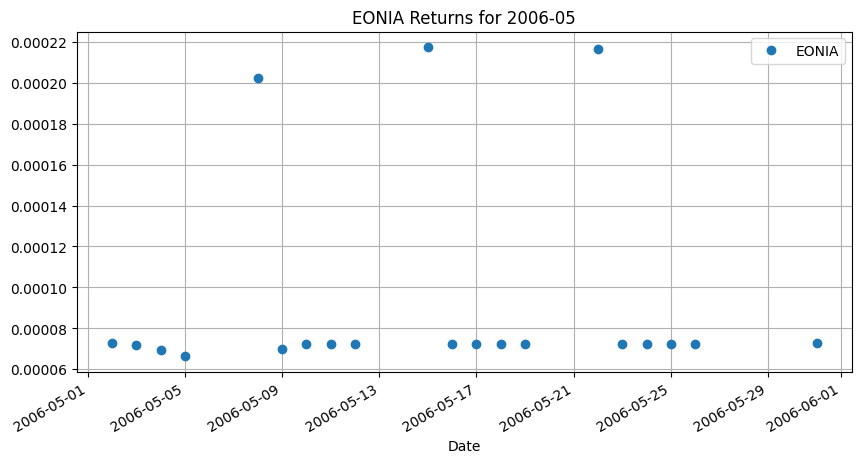

In [4]:
month = '2006-05'  # Change this to the desired year and month (YYYY-MM)
filtered_df = returns_df.loc[month]

# Plot
filtered_df.plot(y='EONIA', marker='o', linestyle='', figsize=(10, 5), grid=True, title=f"EONIA Returns for {month}")



<Axes: xlabel='Date'>

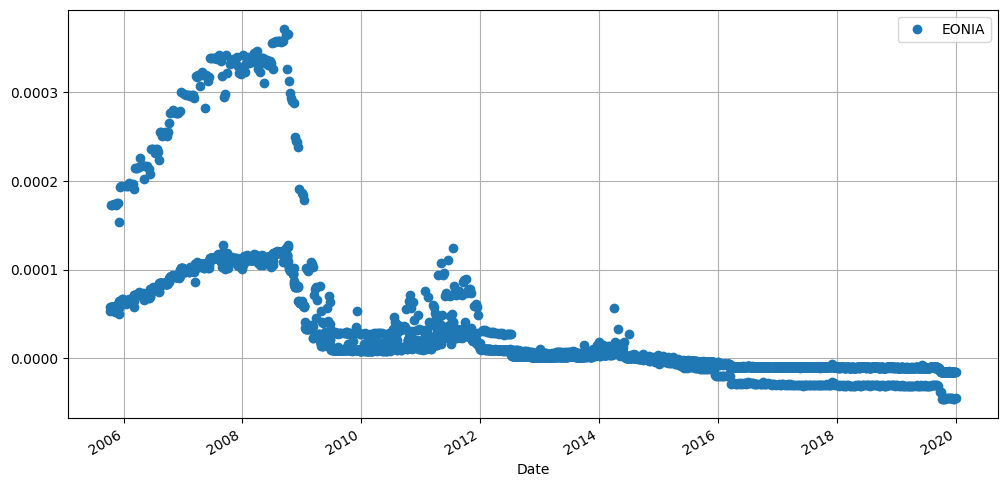

In [5]:
returns_df.plot(y='EONIA', marker='o', linestyle='', figsize=(12,6), grid=True)

In [6]:
from gan5 import GAN5
from gan6 import GAN6
from gan7 import GAN7

for asset_name in returns_df.columns:
    print(f"Training WGAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    # Create WGAN instance for the current asset
    gan = GAN7(asset_returns, asset_name)
    
    # Train WGAN for this asset
    gan.train()
    gan.generate_scenarios(num_scenarios=10000)
    
    print(f"Finished training WGAN for {asset_name}.\n")


Training WGAN for EONIA...
[Epoch 0/1800] [Batch 0/16] [D loss: 0.03700340539216995] [G loss: -0.1036958321928978]
[Epoch 0/1800] [Batch 10/16] [D loss: -0.7144144773483276] [G loss: -0.19540268182754517]
[Epoch 1/1800] [Batch 0/16] [D loss: -1.2542572021484375] [G loss: -0.25601139664649963]
[Epoch 1/1800] [Batch 10/16] [D loss: -2.2398481369018555] [G loss: -0.33502256870269775]
[Epoch 2/1800] [Batch 0/16] [D loss: -2.816267967224121] [G loss: -0.4288059175014496]
[Epoch 2/1800] [Batch 10/16] [D loss: -3.7532835006713867] [G loss: -0.5492046475410461]
[Epoch 3/1800] [Batch 0/16] [D loss: -4.2608113288879395] [G loss: -0.7002731561660767]
[Epoch 3/1800] [Batch 10/16] [D loss: -5.356143951416016] [G loss: -0.8266098499298096]
[Epoch 4/1800] [Batch 0/16] [D loss: -5.7291107177734375] [G loss: -0.9830313920974731]
[Epoch 4/1800] [Batch 10/16] [D loss: -6.715631484985352] [G loss: -1.0110576152801514]
[Epoch 5/1800] [Batch 0/16] [D loss: -7.27573823928833] [G loss: -1.1254373788833618]
[E

In [7]:
def create_rolling_empirical(returns_df, window_size=252):
    """Creates rolling 1-year (252-day) sequences from empirical data"""
    rolling_data = []
    for i in range(len(returns_df) - window_size):
        window = returns_df[i : i + window_size]
        rolling_data.append(window)
    return np.array(rolling_data)

def check_mode_collapse(real_returns, generated_returns):
    """
    Checks for mode collapse using:
    1. Variance comparison.
    2. Sample diversity (pairwise distance).
    3. PCA visualization.
    """

    real_var = np.var(real_returns, axis=0).mean()  # Average variance across time steps
    gen_var = np.var(generated_returns, axis=0).mean()

    print(f"Variance of Real Data: {real_var:.6f}")
    print(f"Variance of Generated Data: {gen_var:.6f}")

    if gen_var < 0.5 * real_var:
        print("⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data")
    else:
        print("✅ Generated Data Shows Reasonable Variance")

    # Check for diversity using pairwise distances
    real_distances = pdist(real_returns, metric="euclidean")
    gen_distances = pdist(generated_returns, metric="euclidean")

    real_mean_dist = np.mean(real_distances)
    gen_mean_dist = np.mean(gen_distances)

    print(f"Mean Pairwise Distance (Real): {real_mean_dist:.6f}")
    print(f"Mean Pairwise Distance (Generated): {gen_mean_dist:.6f}")

    if gen_mean_dist < 0.5 * real_mean_dist:
        print("⚠️ Warning: Potential Mode Collapse - Samples are too similar")
    else:
        print("✅ Generated samples are reasonably diverse")

    # PCA Projection for real vs generated data
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_returns)
    gen_pca = pca.transform(generated_returns)

    plt.figure(figsize=(8, 6))
    plt.scatter(real_pca[:, 0], real_pca[:, 1], color="blue", label="Real Returns", alpha=0.5)
    plt.scatter(gen_pca[:, 0], gen_pca[:, 1], color="red", label="Generated Returns", alpha=0.5)
    plt.legend()
    plt.title("PCA Projection of Real vs Generated Returns")
    plt.show()

# ---------- PLOTTING FUNCTION ---------- #
def plot_distributions_with_mode_collapse_check(returns_df):
    asset_names = returns_df.columns

    plt.figure(figsize=(12, 6))

    for asset_name in asset_names:
        # Load the generated returns for each asset
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt')

        # Reshape if needed (batch_size, 252 days)
        gen_returns = gen_returns.view(gen_returns.size(0), 252).cpu().detach().numpy()
        
        # Take rolling 252-day sequences instead of trying to reshape
        empirical_returns = create_rolling_empirical(returns_df[asset_name].values, window_size=252)

        # KDE Plot
        sns.kdeplot(empirical_returns.flatten(), label=f"{asset_name} - Empirical", linestyle="dashed", linewidth=2)
        sns.kdeplot(gen_returns.flatten(), label=f"{asset_name} - Generated", linewidth=2)

        # Check for mode collapse using **252-day sequences**
        check_mode_collapse(empirical_returns, gen_returns)

    plt.title('Distribution of Returns for All Assets', fontsize=16)
    plt.xlabel('Return', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(title='Assets', fontsize=12)
    plt.grid(True)
    plt.show()

# HISTOGRAM PLOT
def plot_histogram_distributions(returns_df, bins=500):
    asset_names = returns_df.columns

    plt.figure(figsize=(10, 6))

    for asset_name in asset_names:
        # Load the generated returns
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt').cpu().detach().numpy()

        # Take rolling 252-day sequences instead of trying to reshape
        empirical_returns = create_rolling_empirical(returns_df[asset_name].values, window_size=252)

        # Ensure both have the same length by truncating
        min_length = min(len(empirical_returns.flatten()), len(gen_returns.flatten()))

        real_data = empirical_returns.flatten()[:min_length]
        generated_data = gen_returns.flatten()[:min_length]

        # Compute statistics for real and generated data
        stats_real = {
            "Mean": np.mean(real_data),
            "Std Dev": np.std(real_data),
            "Skewness": stats.skew(real_data),
            "Kurtosis": stats.kurtosis(real_data)
        }

        stats_generated = {
            "Mean": np.mean(generated_data),
            "Std Dev": np.std(generated_data),
            "Skewness": stats.skew(generated_data),
            "Kurtosis": stats.kurtosis(generated_data)
        }

        # Print statistical properties
        print(f"\nStatistical Summary for {asset_name} - Real Data:")
        for k, v in stats_real.items():
            print(f"{k}: {v:.6f}")

        print(f"\nStatistical Summary for {asset_name} - Generated Data:")
        for k, v in stats_generated.items():
            print(f"{k}: {v:.6f}")

        # Create Histogram instead of KDE
        plt.hist(real_data, bins=bins, alpha=0.6, color='blue', label=f"{asset_name} - Real", density=True)
        plt.hist(generated_data, bins=bins, alpha=0.6, color='red', label=f"{asset_name} - Generated", density=True)

        plt.title(f'Distribution of Returns for {asset_name}', fontsize=14)
        plt.xlabel('Return', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True)

        plt.show()

# EXTREME VALUE PLOT

def extreme_value_analysis(returns_df):
    asset_names = returns_df.columns
    
    for asset_name in asset_names:
        # Load generated returns
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt')
        gen_returns = gen_returns.view(gen_returns.size(0), 252).cpu().detach().numpy().flatten()
        
        # Get real returns
        real_returns = returns_df[asset_name].values.flatten()
        
        # ---- Tail Histogram (Log-Log Scale) ----
        plt.figure(figsize=(8, 5))
        plt.hist(abs(real_returns), bins=100, alpha=0.6, label=f'{asset_name} - Real', density=True, log=True)
        plt.hist(abs(gen_returns), bins=100, alpha=0.6, label=f'{asset_name} - Generated', density=True, log=True)
        plt.xlabel('Absolute Return (log scale)')
        plt.ylabel('Frequency (log scale)')
        plt.title(f'Tail Histogram (Log-Log) for {asset_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # ---- Tail Quantile Plot ----
        quantiles = np.linspace(0.01, 0.99, 50)
        real_quantiles = np.quantile(real_returns, quantiles)
        gen_quantiles = np.quantile(gen_returns, quantiles)
        
        plt.figure(figsize=(8, 5))
        plt.plot(quantiles, real_quantiles, label='Real Returns', marker='o', linestyle='dashed')
        plt.plot(quantiles, gen_quantiles, label='Generated Returns', marker='s', linestyle='dashed')
        plt.xlabel('Quantile')
        plt.ylabel('Return')
        plt.title(f'Tail Quantile Plot for {asset_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

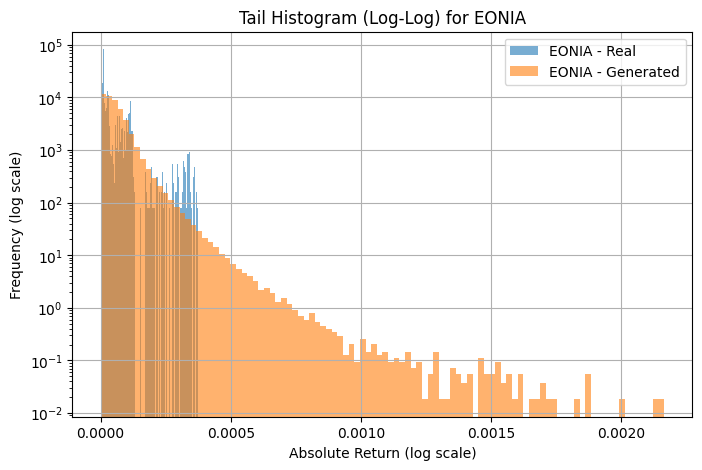

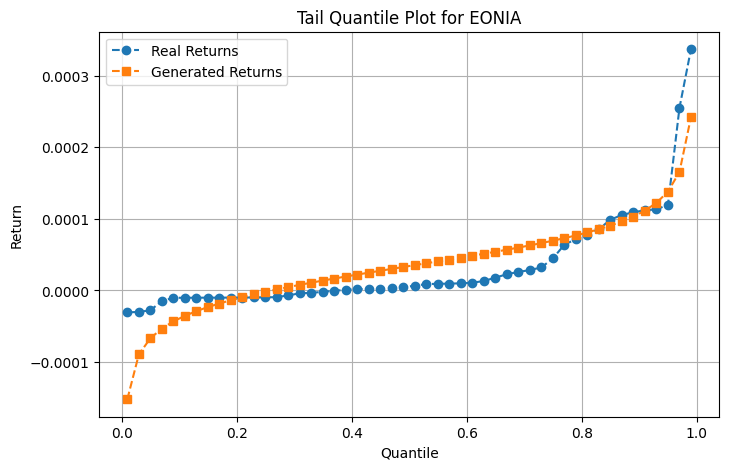

In [8]:
try:
    extreme_value_analysis(returns_df)
except:
    print("YOYOYOYO")


Statistical Summary for EONIA - Real Data:
Mean: 0.000032
Std Dev: 0.000069
Skewness: 2.682698
Kurtosis: 8.158064

Statistical Summary for EONIA - Generated Data:
Mean: 0.000035
Std Dev: 0.000074
Skewness: 0.004334
Kurtosis: 28.356102


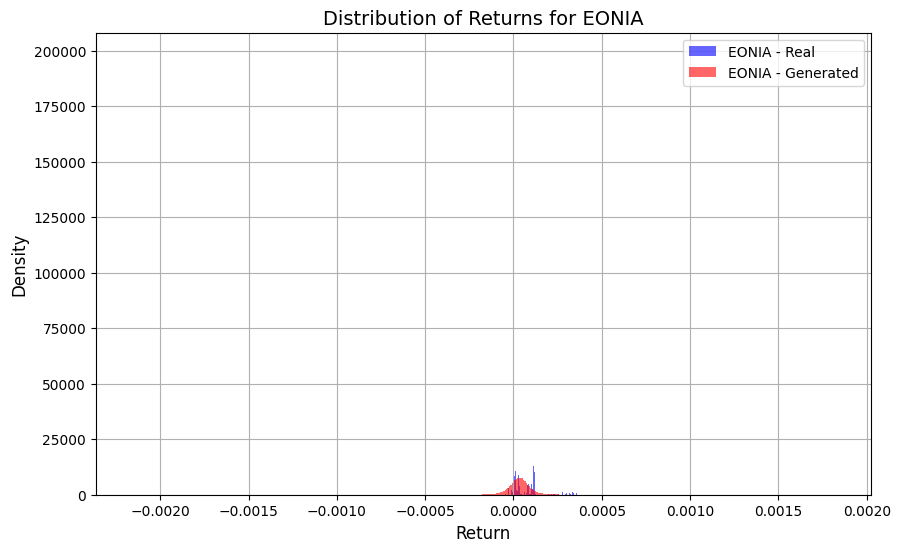

In [9]:
try:
    plot_histogram_distributions(returns_df)
except:
    print("YO")

Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.001185
✅ Generated samples are reasonably diverse


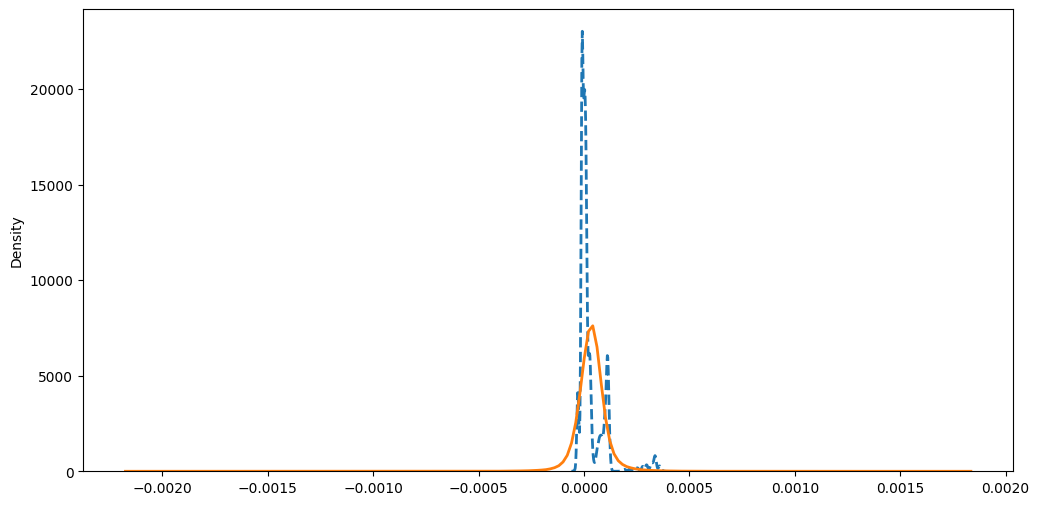

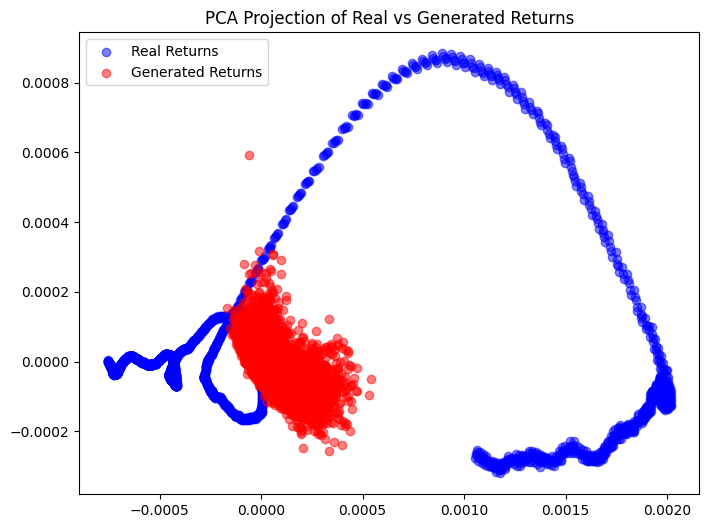

/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_65332/1396322960.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Assets', fontsize=12)


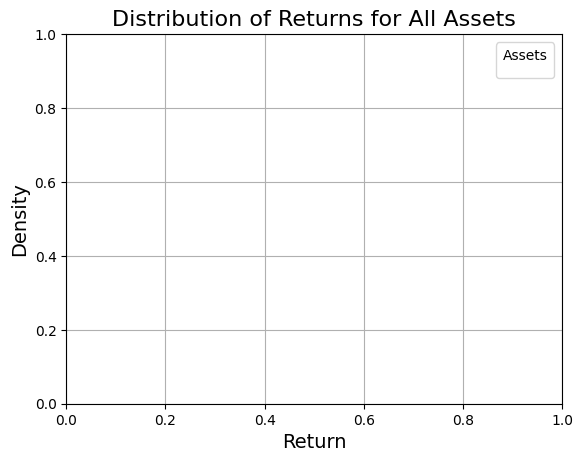

In [10]:
try:
    plot_distributions_with_mode_collapse_check(returns_df)
except:
    print("YO")